# Natural Language Processing with Disaster Tweets

Importing all packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import re
import nltk
from sklearn import feature_extraction, linear_model, model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\karno\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Reading data from files (test and train)

In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

Example data

In [3]:
df_train



,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


Number of all records

In [5]:
df_train['id'].count()

7613

Count and graph of non-disaster/disaster tweets

In [6]:
df_train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

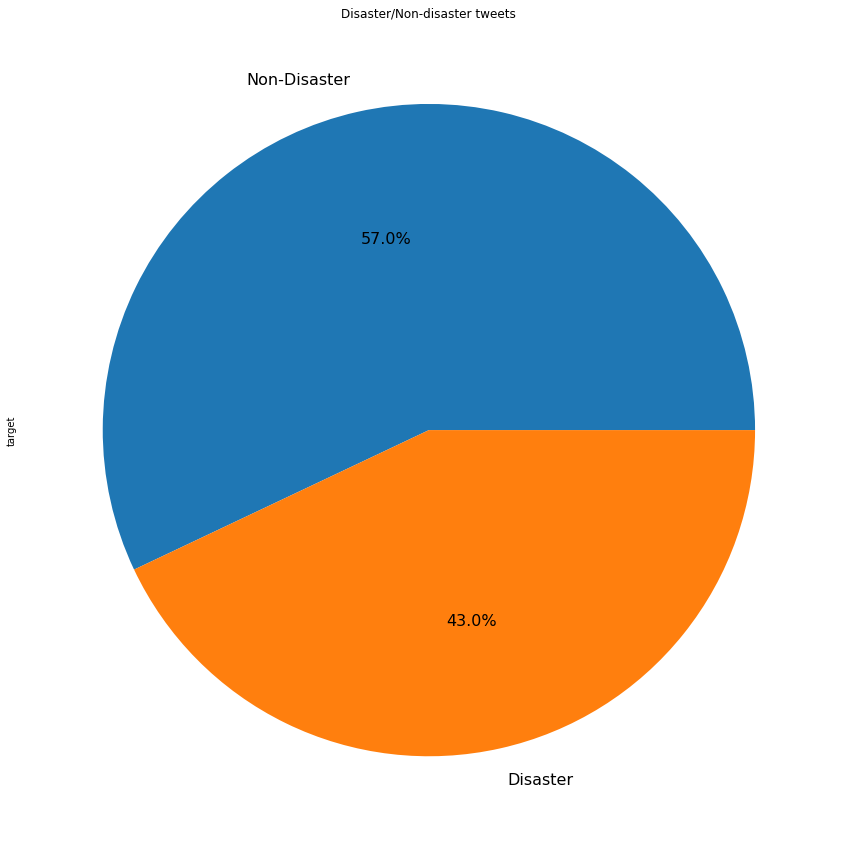

In [7]:
df_train['target'].value_counts().plot(kind='pie',
                                         title='Disaster/Non-disaster tweets', 
                                         autopct='%1.1f%%',
                                         shadow=False,
                                         labels=['Non-Disaster', 'Disaster'],
                                         legend = False, fontsize=16, figsize=(15,15))
plt.show()

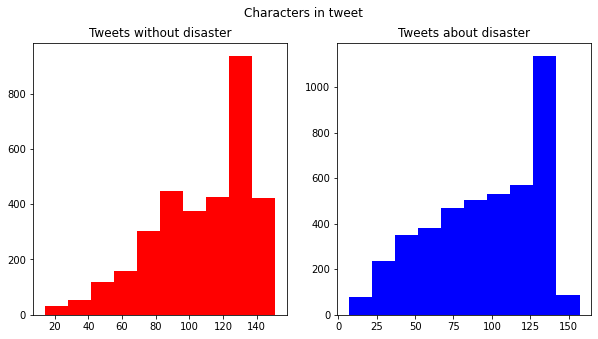

In [8]:
fig, (ax1, ax2)=plt.subplots(1,2,figsize = (10,5))
disaster_tweets_len = df_train[df_train['target']==1]['text'].str.len()
ax1.hist(disaster_tweets_len, color = 'red')
ax1.set_title('Tweets without disaster')

notdisaster_tweets_len = df_train[df_train['target']==0]['text'].str.len()
ax2.hist(notdisaster_tweets_len, color = 'blue')
ax2.set_title('Tweets about disaster')

fig.suptitle('Characters in tweet')
plt.show()

List of the most occurring words in keyboard (general)

In [9]:
df_train.keyword.value_counts().sort_values(ascending=False)

fatalities               45
armageddon               42
deluge                   42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

List of the most occurring words in keyboard (only in disaster tweets)

In [10]:
df_train_true_key = df_train[df_train['target'] == 1].keyword.value_counts().sort_values(ascending=False)
df_train_true_key

derailment     39
outbreak       39
wreckage       39
debris         37
typhoon        37
               ..
blazing         1
epicentre       1
body%20bag      1
electrocute     1
ruin            1
Name: keyword, Length: 220, dtype: int64

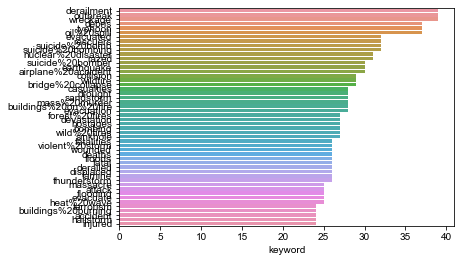

In [11]:
sns.barplot(y = df_train_true_key.index[:50], x = df_train_true_key[:50])
sns.set(rc={'figure.figsize':(20, 10)})

# Cleaning data



Change all text to lower case

In [12]:
df_train['text'].head()

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object

In [13]:

def lowerText(text):
    text = text.lower()
    return text

df_train['text'] = df_train['text'].apply(lambda x : lowerText(x))

df_train['text'].head()

0    our deeds are the reason of this #earthquake m...
1               forest fire near la ronge sask. canada
2    all residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    just got sent this photo from ruby #alaska as ...
Name: text, dtype: object

removing all links from our data

In [14]:
ex = df_train.iloc[40,3]
ex

'check these out: http://t.co/roi2nsmejj http://t.co/3tj8zjin21 http://t.co/yduixefipe http://t.co/lxtjc87kls #nsfw'

In [15]:
def delete_links(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [16]:
df_train['text'] = df_train['text'].apply(lambda sentence: delete_links(sentence))

In [17]:
ex = df_train.iloc[40,3]
ex

'check these out:     #nsfw'

Change acronyms to normal words

In [18]:
ex2 = df_train.iloc[3071,3]
ex2

"i wanna tweet a 'niall thx for not making me was to electrocute myself' tweet but i'm scared i'll jinx it"

In [19]:
df_train.replace(regex={'afaik':'as far as i know',
' afk ':' away from keyboard ',
' asap ':' as soon as possible ',
' atk ':' at the keyboard ',
' atm ':' at the moment ',
' a3 ':' anytime, anywhere, anyplace ',
' bak ':' back at keyboard ',
' bbl ':' be back later ',
' bbs ':' be back soon ',
' bfn ':' bye for now ',
' b4n ':' bye for now ',
' brb ':' be right back ',
' brt ':' be right there ',
' btw ':' by the way ',
' b4 ':' before ',
' b4n ':' bye for now ',
' cu ':' see you ',
' cul8r ':' see you later ',
' cya ':' see you ',
' faq ':' frequently asked questions ',
' fc ':' fingers crossed ',
' fwiw ':" for what it's worth ",
' fyi ':' for your information ',
' gal ':' get a life ',
' gg ':' good game ',
' gn ':' good night ',
' gmta ':' great minds think alike ',
' gr8 ':" great! ",
' g9 ':" genius ",
' ic ':" i see ",
' icq ':" i seek you ",
' ilu ':" i love you ",
' imho ':" in my honest opinion ",
' imo ':" in my opinion ",
' iow ':" in other words ",
' irl ':" in real life ",
' kiss ':" keep it simple, stupid ",
' ldr ':" long distance relationship ",
' lmao ':" laugh my ass ",
' lol ':" laughing out loud ",
' ltns ':" long time no see ",
' l8r ':" later ",
' mte ':" my thoughts exactly ",
' m8 ':" mate ",
' nrn ':" no reply necessary ",
' oic ':" oh i see ",
' pita ':" pain in the ass ",
' prt ':" party ",
' prw ':" parents are watching ",
' rofl ':" rolling on the floor laughing ",
' roflol ':" rolling on the floor laughing out loud ",
' rotflmao ':" rolling on the floor laughing my ass ",
' sk8 ':" skate ",
' stats ':" your sex and age ",
' asl ':" age, sex, location ",
' thx ':" thank you ",
' ttfn ':" ta-ta for now! ",
' ttyl ':" talk to you later ",
' u ':" you ",
' u2 ':" you too",
' u4e ':" yours for ever ",
' wb ':" welcome back ",
' wtf ':" what the fuck ",
' wtg ':" way to go! ",
' wuf ':" where are you from? ",
' w8 ':" wait... ",},inplace=True)

In [20]:
ex2 = df_train.iloc[3071,3]
ex2

"i wanna tweet a 'niall thank you for not making me was to electrocute myself' tweet but i'm scared i'll jinx it"

Delete all stop words

In [21]:
stopWords = nltk.corpus.stopwords.words('english')
df_train.iloc[2000,3]

'@bradleybrad47 the saw is fast af and does great damage i upgraded it a shitton and used it exclusively for a whole playthrough'

In [22]:
df_train['text'] = df_train['text'].apply(lambda x:' '.join([word for word in x.split() if word not in (stopWords)]))
df_train.iloc[2000,3]

'@bradleybrad47 saw fast af great damage upgraded shitton used exclusively whole playthrough'

# Tokenization

In [23]:
#tokenizator = nltk.tokenize.RegexpTokenizer(r'\w+')
#df_train['text'] = df_train['text'].apply(lambda x:tokenizator.tokenize(x))
#df_train.head()

# vectorization

In [24]:
count_vectorization = feature_extraction.text.CountVectorizer()
train_vector = count_vectorization.fit_transform(df_train['text'])

# Model

Ridge regression classifier

In [25]:
mod = linear_model.RidgeClassifier()
scores = model_selection.cross_val_score(mod,train_vector,df_train['target'],cv = 5,scoring="f1")
scores

array([0.5992714 , 0.44752819, 0.54340836, 0.4800759 , 0.65187452])

In [26]:
mod.fit(train_vector,df_train["target"])

RidgeClassifier()

Logistic regression classifier

In [27]:
mod2 = LogisticRegression(C=1.0)
scores = model_selection.cross_val_score(mod2,train_vector,df_train['target'],cv = 5,scoring="f1")
scores

array([0.60518732, 0.50902837, 0.57502096, 0.52165544, 0.71033938])

In [28]:
mod2.fit(train_vector,df_train["target"])

LogisticRegression()

Naives Bayes Classifier

In [29]:
mod3 = MultinomialNB()
scores = model_selection.cross_val_score(mod3,train_vector,df_train['target'],cv = 5,scoring="f1")
scores

array([0.63070539, 0.62004326, 0.68852459, 0.64212999, 0.7264214 ])

In [30]:
mod3.fit(train_vector,df_train["target"])

MultinomialNB()